<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_ML_DT_XG_RF_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [75]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### General Function Setup

In [5]:
#one hot encoding function
def one_hot(df):
    y = df['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
    x = df.drop('y', axis=1)
    x_dum = pd.get_dummies(x)
    return x, y


#train_test_split
def scale_split(x, y, test_size):
    scaler = MinMaxScaler()
    df_sca = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = test_size, random_state=42)
    print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)
    return x_train,x_test,y_train,y_test


### Data Transformation - V1 (Agreed on Team Discussion)

In [6]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [7]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [8]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [9]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [10]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [11]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [12]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### One Hot Encoding For Categorical Features

In [13]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [14]:
x = df_tran_1.drop('y', axis=1)

In [67]:
df_raw = pd.get_dummies(x)
df_raw.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [68]:
#drop the unknow columns to resolve the multicollinearity

df_raw = df_raw.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown', 'edu_new_unknown', 'job_new_unknown'], axis=1)
df_raw.shape

(41170, 38)

In [70]:
cols = df_raw.columns

### Train-Test Split & Data Normalization

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
df_raw = scaler.fit_transform(df_raw)

In [25]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(df_raw, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 38) (8234, 38) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [26]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [27]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


In [28]:
y_s.value_counts()

0    29227
1    29227
Name: y, dtype: int64

### ML Model Training - Decision Tree w/p PCA

In [72]:
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(x_s, y_s)

DecisionTreeClassifier(max_depth=5)

In [97]:
from sklearn.metrics import cohen_kappa_score,  average_precision_score


# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print("Kappa- ", cohen_kappa_score(y_test, predictions))
    print("F1- ", f1_score(y_test, predictions))
    print("ROC_AUC_score- ", roc_auc_score(y_test, predictions))
    print("PR AUC- ", average_precision_score(y_test, predictions))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_curve(y_test, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    fig.tight_layout()
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, predictions)
    ax2.set_title('Precision-Recall AUC Curve')
    ax2.plot(lr_recall, lr_precision, marker='.')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.show()

In [41]:
preds_dt = dtree.predict(x_test)
# preds_dt =  [1 if i>0.5 else 0 for i in preds_dt]

In [46]:
print_validation_report(y_test, preds_dt)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      7307
           1       0.30      0.34      0.32       927

    accuracy                           0.84      8234
   macro avg       0.61      0.62      0.61      8234
weighted avg       0.85      0.84      0.84      8234

Accuracy Score: 0.8379888268156425
Kappa-  0.2284358106907326
F1-  0.3200815494393476
ROC_AUC_score-  0.6200272853874069
PR AUC-  0.1772109900244645


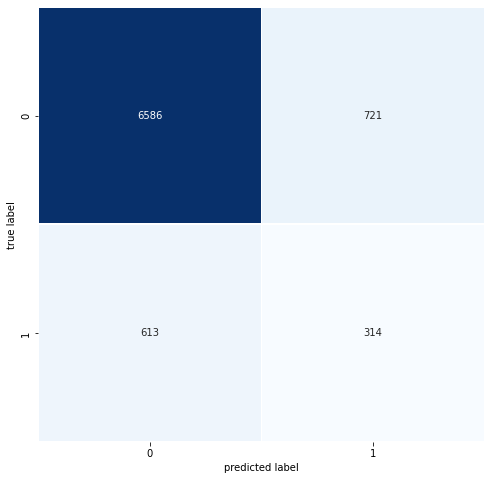

In [47]:
plot_confusion_matrix(y_test, preds_dt)

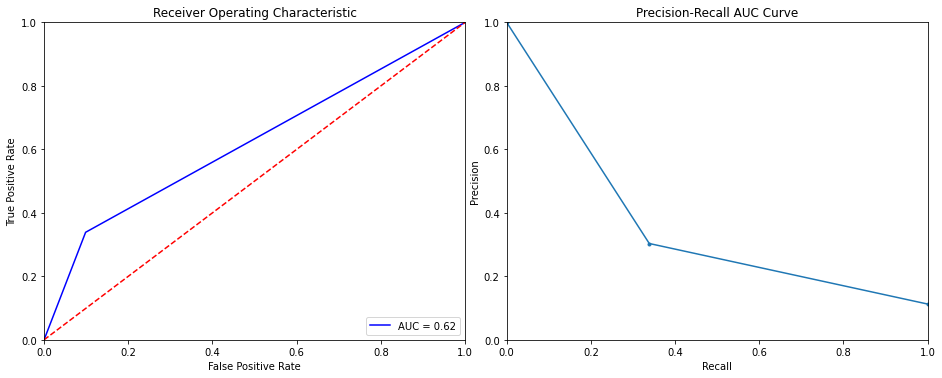

In [48]:
plot_curve(y_test, preds_dt)

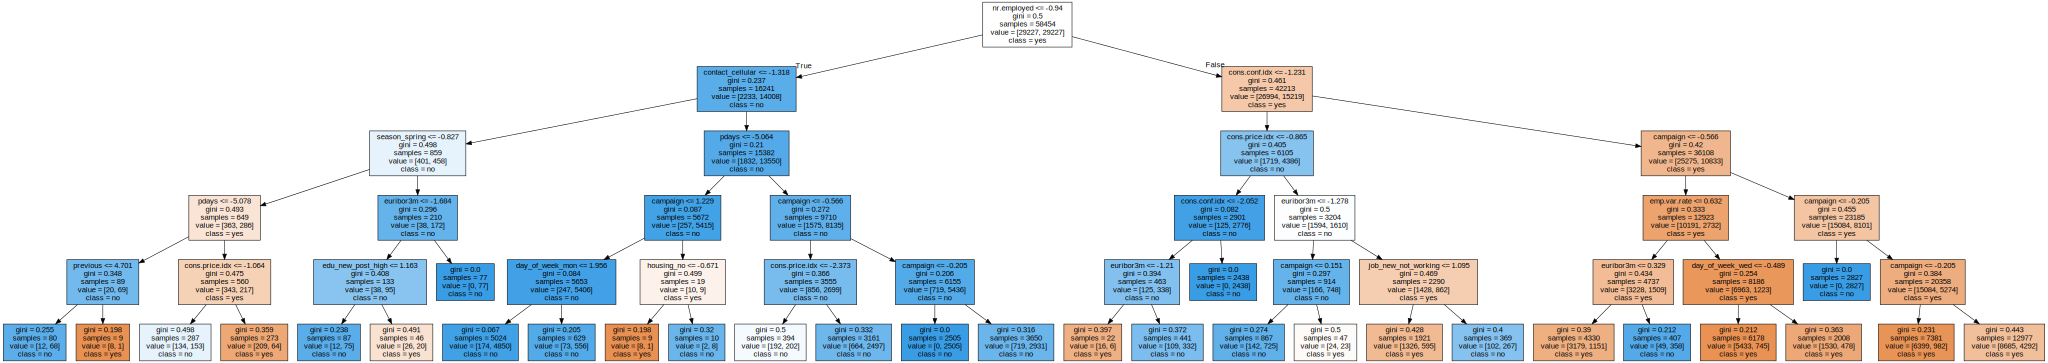

In [80]:
feature_cols = list(cols) 

import graphviz
dt_graph = export_graphviz(dtree, out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['yes', 'no'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dt_graph, format="png") 
graph

###Hyperparameter Tuning using GridSearchCV
######apply best estimator to do another classification

In [55]:
param_dict = {
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(3,8),
    'min_samples_split':np.arange(5,10),
    'min_samples_leaf':np.arange(3,10),
}

grid = GridSearchCV(dtree, 
                    param_grid =param_dict, 
                    cv= 5,
                    verbose=1, n_jobs = -1)

grid.fit(x_s, y_s)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([5, 6, 7, 8, 9])},
             verbose=1)

In [56]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [57]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5)

In [58]:
grid.best_score_

0.8427827624929034

In [82]:
dt_best = DecisionTreeClassifier(max_depth=7, 
                                min_samples_leaf=3, 
                                min_samples_split=5,
                                criterion = 'gini')

dt_best.fit(x_s, y_s)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5)

In [92]:
preds_grid = dt_best.predict(x_test)
preds_grid =  [1 if i>0.5 else 0 for i in preds_grid]

In [94]:
print_validation_report(y_test, preds_grid)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7307
           1       0.48      0.55      0.51       927

    accuracy                           0.88      8234
   macro avg       0.71      0.74      0.72      8234
weighted avg       0.89      0.88      0.89      8234

Accuracy Score: 0.8814670876852077
Kappa-  0.44298608405074213
F1-  0.5100401606425702
ROC_AUC_score-  0.7358880203685224
PR AUC-  0.31228205335145565


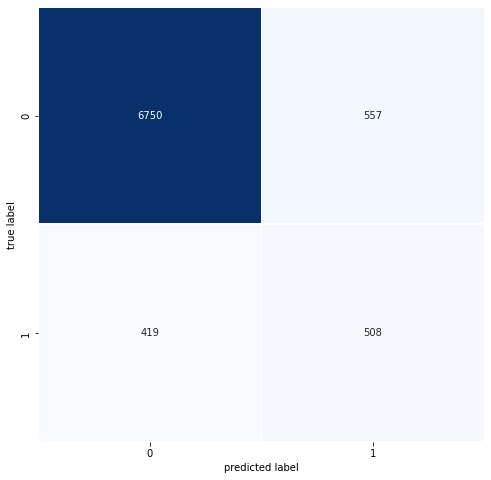

In [98]:
plot_confusion_matrix(y_test, preds_grid)

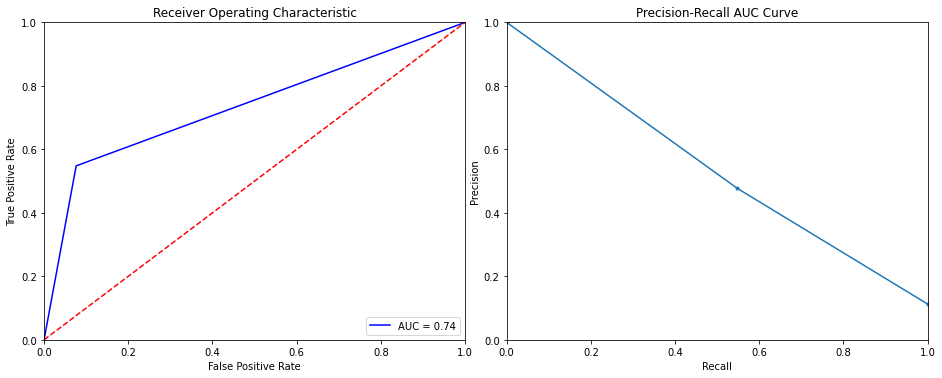

In [99]:
plot_curve(y_test, preds_grid)

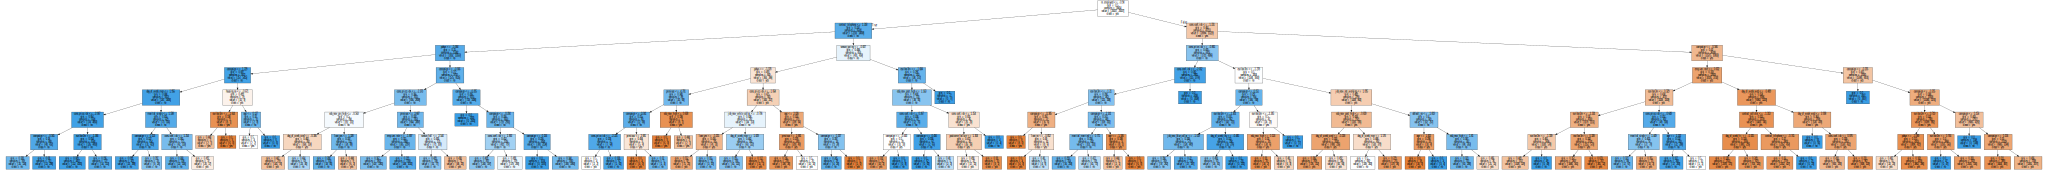

In [100]:
feature_cols = list(cols) 

import graphviz
dt_graph = export_graphviz(dt_best, out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['yes', 'no'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dt_graph, format="png") 
graph

### Random Forest - extended from bagging



In [102]:
rf = RandomForestClassifier(random_state=42,
                            max_depth=7, 
                            min_samples_leaf=3, 
                            min_samples_split=5,
                            criterion = 'gini' )

rf.fit(x_s, y_s)

RandomForestClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [106]:
preds_rf = rf.predict(x_test)
preds_rf =  [1 if i>0.5 else 0 for i in preds_rf]

In [110]:
print_validation_report(y_test, preds_rf)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      7307
           1       0.44      0.61      0.51       927

    accuracy                           0.87      8234
   macro avg       0.69      0.76      0.72      8234
weighted avg       0.89      0.87      0.88      8234

Accuracy Score: 0.868350740830702
Kappa-  0.4375590204554676
F1-  0.5112714156898107
ROC_AUC_score-  0.7562837072045557
PR AUC-  0.31235463816675035


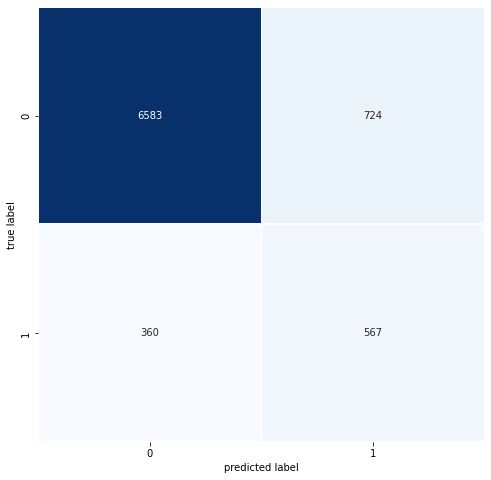

In [111]:
plot_confusion_matrix(y_test, preds_rf)

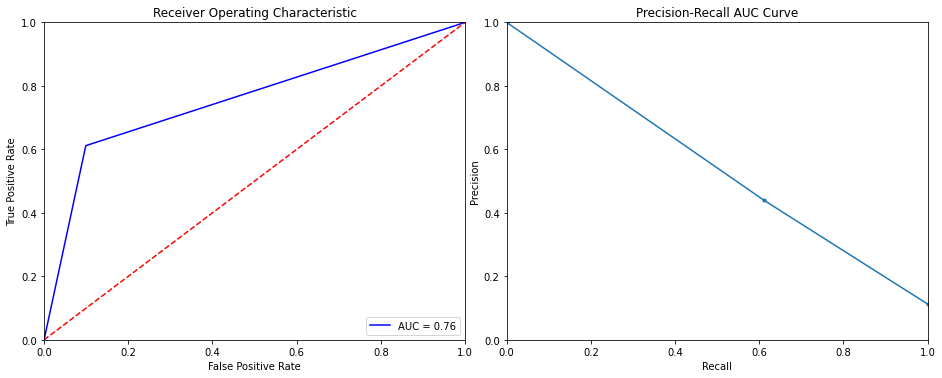

In [112]:
plot_curve(y_test, preds_rf)

###XGBoost Classifier

In [117]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

In [118]:
param_grid_xgb = {
               'max_depth': [5, 7],
               'max_features': [10, 20, 30]}


In [119]:
grid = GridSearchCV(xgb, 
                    param_grid =param_grid_xgb, 
                    cv= 5,
                    verbose=1, n_jobs = -1)

grid.fit(x_s, y_s)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'max_features': [10, 20, 30]},
             verbose=1)

In [120]:
grid.best_params_

{'max_depth': 7, 'max_features': 10}

In [122]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results[["param_max_depth","param_max_features","mean_test_score"]]

,param_max_depth,param_max_features,mean_test_score
0,5,10,0.912428
1,5,20,0.912428
2,5,30,0.912428
3,7,10,0.917714
4,7,20,0.917714
5,7,30,0.917714


In [125]:
xgb_best = XGBClassifier( max_depth = 7, max_features = 10)
xgb_best.fit(x_s, y_s)

XGBClassifier(max_depth=7, max_features=10)

XGBClassifier(max_depth=7, max_features=10)

In [127]:
preds_xgb_train = xgb_best.predict(x_s)
preds_xgb_train =  [1 if i>0.5 else 0 for i in preds_xgb_train ]

preds_xgb_test = xgb_best.predict(x_test)
preds_xgb_test =  [1 if i>0.5 else 0 for i in preds_xgb_test ]

In [130]:
print_validation_report(y_test, preds_xgb_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7307
           1       0.57      0.39      0.46       927

    accuracy                           0.90      8234
   macro avg       0.75      0.68      0.70      8234
weighted avg       0.89      0.90      0.89      8234

Accuracy Score: 0.8982268642215205
Kappa-  0.40751084197769216
F1-  0.4614395886889461
ROC_AUC_score-  0.6751599484409225
PR AUC-  0.2900159808238429


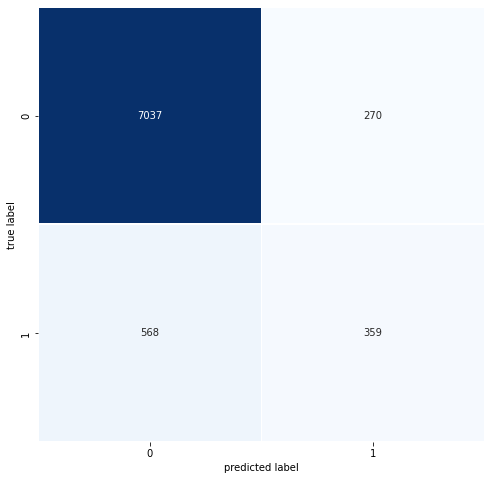

In [131]:
plot_confusion_matrix(y_test, preds_xgb_test)

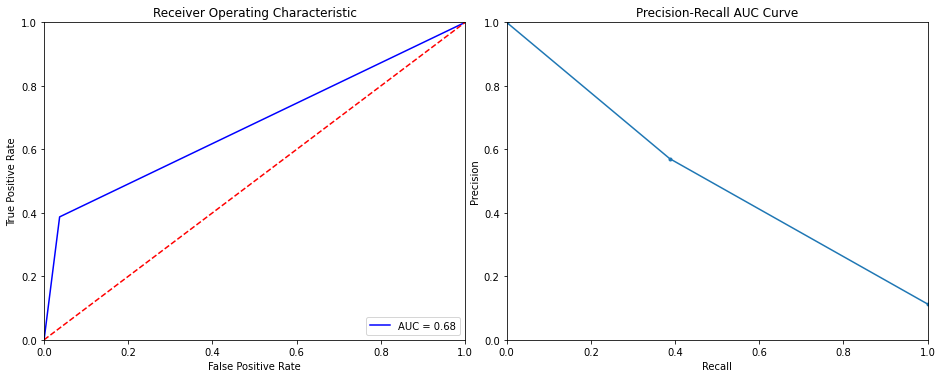

In [132]:
plot_curve(y_test, preds_xgb_test)

###Logistic Regression

In [135]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver='lbfgs', random_state = 100)
lg.fit(x_s, y_s)

LogisticRegression(random_state=100)

In [136]:
preds_lg = lg.predict(x_test)
preds_lg =  [1 if i>0.5 else 0 for i in preds_lg ]

In [137]:
print_validation_report(y_test, preds_lg)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7307
           1       0.32      0.67      0.44       927

    accuracy                           0.80      8234
   macro avg       0.64      0.75      0.66      8234
weighted avg       0.88      0.80      0.83      8234

Accuracy Score: 0.8038620354627156
Kappa-  0.3350166557002181
F1-  0.43630017452006986
ROC_AUC_score-  0.7472635998434509
PR AUC-  0.2541107277428132


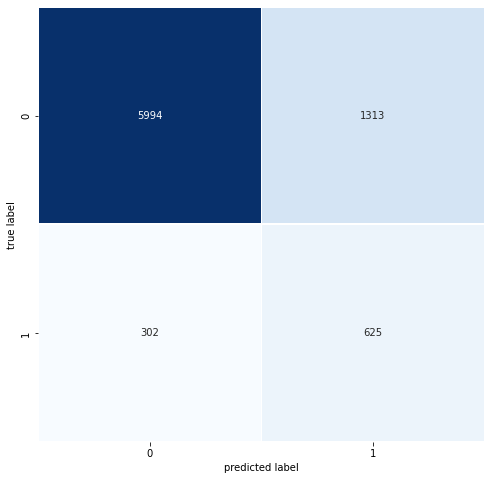

In [138]:
plot_confusion_matrix(y_test, preds_lg)

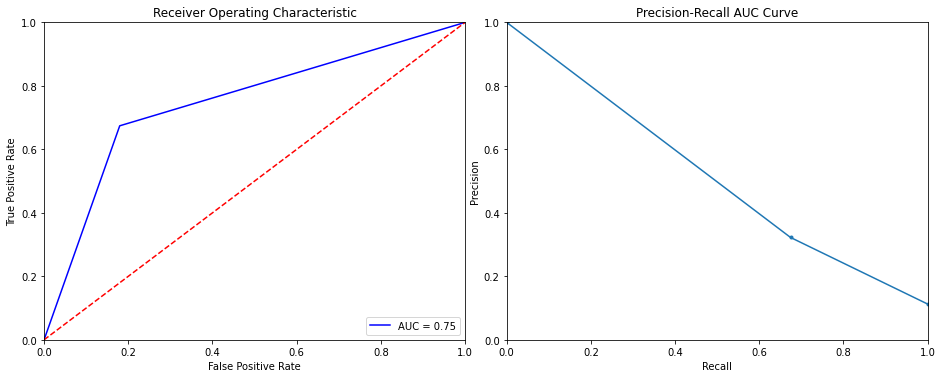

In [139]:
plot_curve(y_test, preds_lg)

###Train the model with duration feature - comparison purpose

In [ ]:
data_dur = data_1.copy()

In [ ]:
df_dur = data_dur[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [ ]:
y = df_dur['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

In [ ]:
x = df_dur.drop('y', axis=1)

In [ ]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [ ]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_3.shape

(41170, 33)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_3 = scaler.fit_transform(df_raw_3)

In [ ]:
x_3

array([[0.48148148, 0.05307035, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.03029687, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.04595364, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.03843026, 0.01818182, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.08987393, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.7037037 , 0.04859699, 0.03636364, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(x_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32936, 33) (8234, 33) (32936,) (8234,)


In [ ]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32936
Resampled dataset shape 58454


In [ ]:
y_s3.value_counts()

0    29227
1    29227
Name: y, dtype: int64

In [ ]:
model3 = Sequential()
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s3.shape[1]))
model3.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [ ]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                544       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7890 - val_loss: 0.9856 - val_accuracy: 0.4475
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4224 - accuracy: 0.8160 - val_loss: 0.8085 - val_accuracy: 0.5251
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3583 - accuracy: 0.8400 - val_loss: 0.6859 - val_accuracy: 0.6417
Epoch 4/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3228 - accuracy: 0.8588 - val_loss: 0.6096 - val_accuracy: 0.7239
Epoch 5/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3100 - accuracy: 0.8656 - val_loss: 0.6349 - val_accuracy: 0.7250
Epoch 6/100
3917/3917 [==============================] - 10s 3ms/step - loss: 0.3033 - accuracy: 0.8698 - val_loss: 0.5197 - val_accuracy: 0.8158
Epoch 7/100
3917/3917 [==============================] - 8s 2ms/step - loss: 0.2993 - accuracy: 0.8706 - val_loss: 0.6350 - val_a

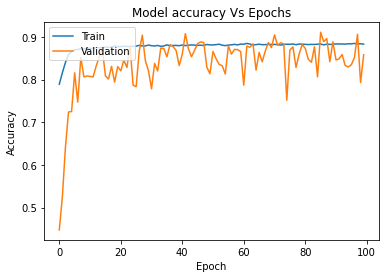

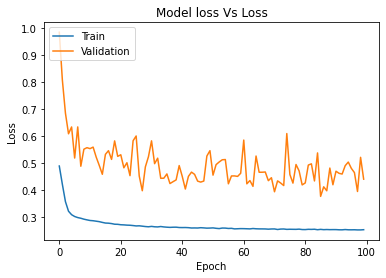

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model3.evaluate(x_test3, y_test3)

258/258 [==============================] - 1s 4ms/step - loss: 0.2146 - accuracy: 0.8911


In [ ]:
preds3 = model3.predict(x_test3)
preds3=np.argmax(preds3, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [ ]:
print_validation_report(y_test3, preds3)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Root Mean Square Error: 0.33553237871752506


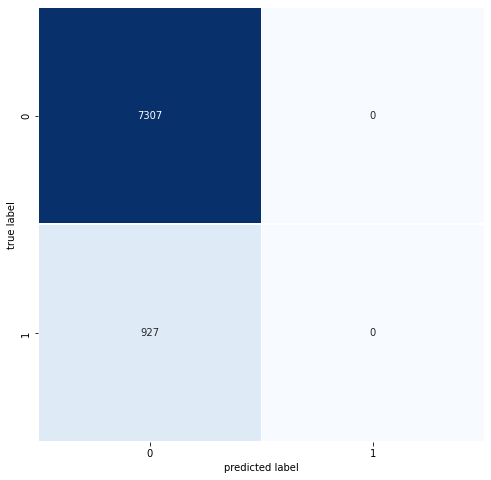

In [ ]:
plot_confusion_matrix(y_test3,preds3)

### Train NN based on original dataset for comparison purpose without duration

In [ ]:
data_2 = data.copy()
df_tran_2 = data_2.drop(['duration'], axis=1)
df_tran_2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
y = df_tran_2['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [ ]:
x = df_tran_2.drop('y', axis=1)

In [ ]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_s

In [ ]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['job_unknown','marital_unknown','education_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1)
df_raw_3.shape

(41188, 56)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw_3 = scaler.fit_transform(df_raw_3)

In [ ]:
df_raw_3

array([[0.48148148, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.01818182, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.7037037 , 0.03636364, 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(df_raw_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32950, 56) (8238, 56) (32950,) (8238,)


In [ ]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32950
Resampled dataset shape 58476


In [ ]:
model3 = Sequential()
model3.add(Flatten(input_shape=( x_s3.shape[1],)))
model3.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [ ]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                3648      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 100, epochs = 100)

Epoch 1/100
392/392 [==============================] - 6s 10ms/step - loss: 0.7030 - accuracy: 0.7544 - val_loss: 1.2525 - val_accuracy: 0.3403
Epoch 2/100
392/392 [==============================] - 3s 7ms/step - loss: 0.5437 - accuracy: 0.8036 - val_loss: 1.1400 - val_accuracy: 0.4307
Epoch 3/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4961 - accuracy: 0.8105 - val_loss: 1.0124 - val_accuracy: 0.4955
Epoch 4/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4750 - accuracy: 0.8111 - val_loss: 1.1058 - val_accuracy: 0.4484
Epoch 5/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4631 - accuracy: 0.8126 - val_loss: 1.0172 - val_accuracy: 0.4962
Epoch 6/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.8132 - val_loss: 1.1322 - val_accuracy: 0.4520
Epoch 7/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4516 - accuracy: 0.8156 - val_loss: 0.9833 - val_accuracy: 0.504

In [ ]:
preds_3 = model3.predict(x_test3)
preds_3 =  [1 if i>0.5 else 0 for i in preds_3]

In [ ]:
print_validation_report(y_test3, preds_3)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7310
           1       0.53      0.41      0.46       928

    accuracy                           0.89      8238
   macro avg       0.73      0.68      0.70      8238
weighted avg       0.88      0.89      0.89      8238

Accuracy Score: 0.8932993445010925
Kappa-  0.40622669683146606
F1-  0.4643510054844607
ROC_AUC_score-  0.6825715540827397
PR AUC-  0.28578739750193977


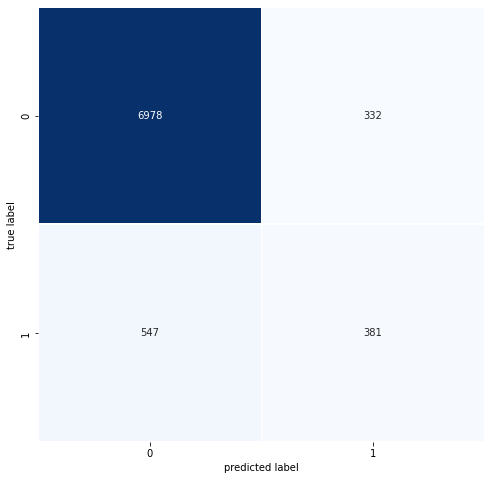

In [ ]:
plot_confusion_matrix(y_test3, preds_3)

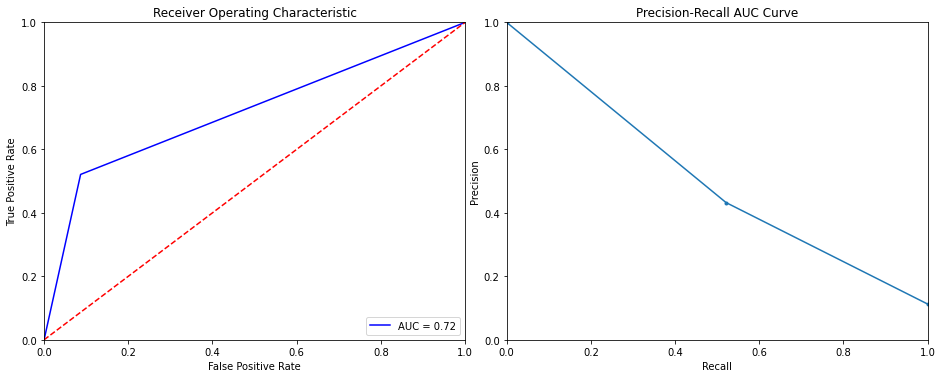

In [ ]:
plot_curve(y_test3, preds_3)

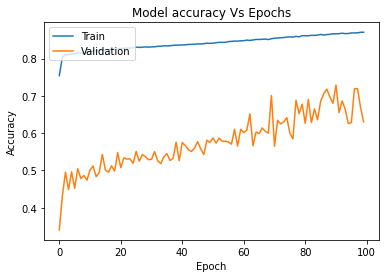

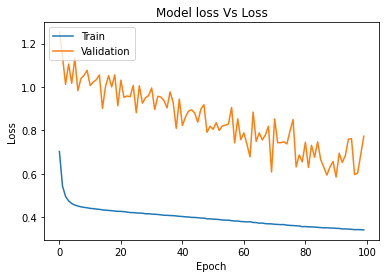

In [ ]:
plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()